In [138]:
import numpy as np
from scipy.special import jv
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import time

In [139]:
def plot_comparison_covariance_matrix_ij(gamma_t_theoretical, gamma_t_numerical, t_values, row, col):
    gamma_real_theoretical = [gamma_t[row-1, col-1].real for gamma_t in gamma_t_theoretical]
    gamma_real_numerical = [gamma_t[  row-1, col-1].real for gamma_t in gamma_t_numerical]
    gamma_imag_theoretical = [gamma_t[row-1, col-1].imag for gamma_t in gamma_t_theoretical]
    gamma_imag_numerical = [gamma_t[  row-1, col-1].imag for gamma_t in gamma_t_numerical]
    plt.figure(figsize=(14, 6))

    plt.plot(t_values,gamma_real_theoretical, label=r"$\mathfrak{R}(\Gamma^{\mathrm{Theoretical}}_{%d,%d})$" % (row, col), color="blue",linestyle="--")
    plt.plot(t_values,gamma_real_numerical, label=r"$\mathfrak{R}(\Gamma^{\mathrm{Numerical}}_{%d,%d})$" % (  row, col),linewidth=2,alpha=0.5, color="red")
    plt.plot(t_values,gamma_imag_theoretical, label=r"$\mathfrak{I}(\Gamma^{\mathrm{Theoretical}}_{%d,%d})$" % (row, col), color="blue", linestyle="--")
    plt.plot(t_values,gamma_imag_numerical, label=r"$\mathfrak{I}(\Gamma^{\mathrm{Numerical}}_{%d,%d})$" %   (row, col), linewidth=2,alpha=0.5,color="red")
    plt.title(r"$\Gamma_{%d,%d}$ Over Time" % (row, col))
    plt.xlabel("$Jt$")
    plt.ylabel(r"$\Gamma_{%d,%d}(Jt)$" % (row, col))
    plt.legend()
    plt.grid(True)

In [140]:
def compute_theoretical_gamma_large_N(N, t_init, t_final, t_step, J,disable_tqdm=False):
    """
    Compute the full Gamma(t) matrix for large N at each time step using vectorized operations.
    Parameters:
        N : size of the covariance matrix (N x N)
        t_init, t_final : time range
        t_step : step size for time
        J : hopping parameter 
    Returns:
        gamma_matrices : list of Gamma matrices for each time step
        t_values : array of time steps
    """
    # Time values
    Jt_values = J * np.arange(t_init, t_final + t_step, t_step)
    
    # Compute distance matrix |j - k| for all indices
    indices = np.arange(1, N + 1)  # Indices start from 1 to N
    delta = np.abs(indices[:, None] - indices)  # |j - k| as a matrix
    
    # Precompute phase matrix (-1)^j * (-1j)^delta
    phase = (-1)**indices[:, None] * (-1j)**delta

    gamma_matrices = []
    
    # Loop over time steps 
    for Jt in tqdm(Jt_values, desc="Computing Theoretical Gamma",disable=disable_tqdm):
        # Diagonal elements (delta == 0)
        gamma_diag = 0.5 + 0.5 * (-1)**indices * jv(0, 2 * Jt)
        
        # Non-diagonal elements (delta > 0)
        gamma_non_diag = 0.5 * phase * jv(delta, 2 * Jt)
        gamma_non_diag[delta == 0] = gamma_diag  # Replace diagonal elements
        
        gamma_matrices.append(gamma_non_diag)

    return gamma_matrices, Jt_values


---
---

In [141]:
def build_hopping_hamiltonian(N,J):
    H = np.zeros((N, N), dtype=complex)
    for i in range(N):
        H[i, (i + 1) % N] = -J/2  
        H[(i + 1) % N, i] = -J/2  
    return H

def compute_time_evolution(gamma, H, t):
    D, P = np.linalg.eigh(H)
    exp_D = np.diag(np.exp(-1j * D *t))
    P_dagger = P.conj().T
    evolved = P @ exp_D @ P_dagger @ gamma @ P @ exp_D.conj().T @ P_dagger
    return evolved

In [142]:
def compute_numerical_gamma(N, J, t_init, t_final, t_step, initial_state,disable_tqdm=False):
    Jt_values = J * np.arange(t_init, t_final + t_step, t_step)
    H = build_hopping_hamiltonian(N, 1)  
    gamma_t_series_circulant = []

    gamma_evolved = initial_state
    for Jt in tqdm(Jt_values, desc="Computing Numerical Evolution",disable=disable_tqdm):
        gamma_evolved = compute_time_evolution(initial_state, H,  Jt)
        gamma_t_series_circulant.append(gamma_evolved)

    return gamma_t_series_circulant, Jt_values

In [143]:
def neel_state(N):   
    neel_state = np.zeros((N, N), dtype=complex)
    for i in range(1, N, 2):  
        neel_state[i, i] = 1
    return neel_state

---
---

In [170]:
N = 200
t_init = 0
t_final = 30
t_step = 0.1
J=3

In [171]:
gamma_theoretical , t_values = compute_theoretical_gamma_large_N(N, t_init, t_final, t_step, J)

Computing Theoretical Gamma: 100%|██████████| 301/301 [00:45<00:00,  6.66it/s]


In [172]:
gamma_numerical , t_values = compute_numerical_gamma(N,J, t_init, t_final, t_step, neel_state(N))

Computing Numerical Evolution: 100%|██████████| 301/301 [00:03<00:00, 96.20it/s] 


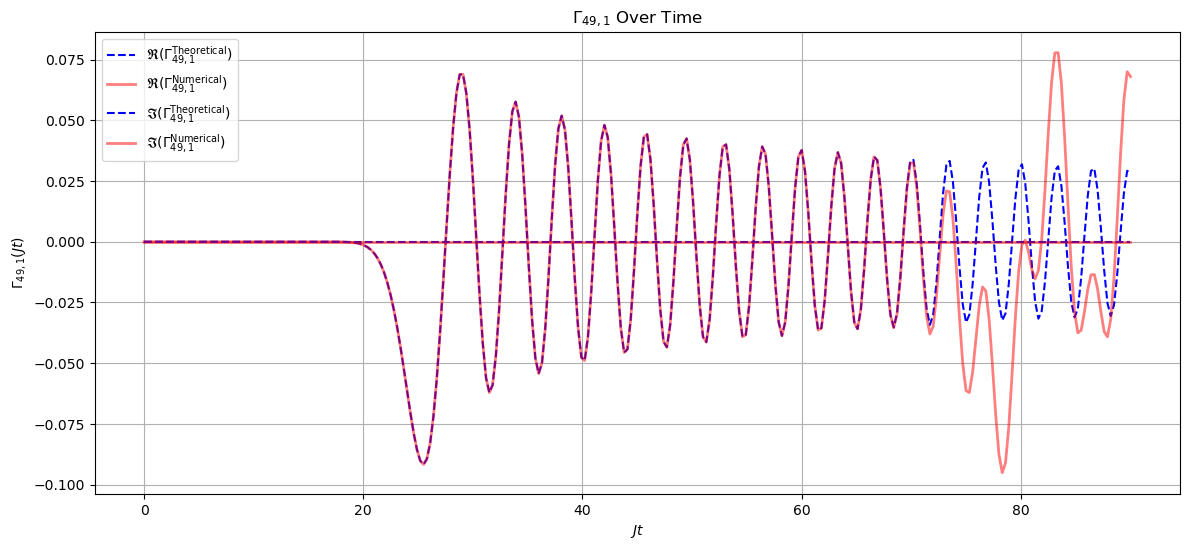

In [173]:
plot_comparison_covariance_matrix_ij(gamma_theoretical, gamma_numerical, t_values, 49,1)

In [148]:
#def compute_divergence_time(N_intial,N_final,N_step, t_init, t_final, t_step, J, threshold,row,col):
#    """
#    Compute the special value of Jt where theoretical and numerical results diverge.
#    Parameters:
#        N_values : list of matrix sizes
#        t_init, t_final : time range
#        t_step : step size for time
#        J : hopping parameter
#        threshold : divergence threshold for relative error
#    Returns:
#        critical_times : list of critical Jt values for each N
#    """
#    critical_times = []
#
#    N_values = np.arange(N_intial, N_final, N_step)
#
#    for N in tqdm(N_values, desc="Processing N values"):
#        # Compute theoretical Gamma
#        gamma_theoretical, Jt_values = compute_theoretical_gamma_large_N(N, t_init, t_final, t_step, J,disable_tqdm=True)
#        
#        # Compute numerical Gamma
#        initial_state = neel_state(N)
#        gamma_numerical, _ = compute_numerical_gamma(N, J, t_init, t_final, t_step, initial_state,disable_tqdm=True)
#        
#        # Compute the divergence time
#        for t_idx, (gamma_th, gamma_num) in enumerate(zip(gamma_theoretical, gamma_numerical)):
#            rel_diff = np.abs((gamma_th[row,col] - gamma_num[row,col]) )
#            if rel_diff > threshold:
#                critical_times.append(Jt_values[t_idx])
#                break
#        else:
#            critical_times.append(np.nan)  # No divergence found within the range
#
#    return critical_times , N_values

In [149]:
#threshold = 0.01 
#N_initial = 50
#N_final=150
#N_step=10
#t_init = 0
#t_final = 30
#t_step = 0.1
#J=10
#
## Compute the critical times
#critical_Jt, N_values = compute_divergence_time(N_initial,N_final,N_step, t_init, t_final, t_step, J, threshold,2,2)

In [150]:
#N_values_reshaped = N_values.reshape(-1, 1)  # Reshape for sklearn
#model = LinearRegression()
#model.fit(N_values_reshaped, critical_Jt)
#a = model.coef_[0]  # Slope
#b = model.intercept_  # Intercept
#
## Generate a smooth line for the linear fit
#N_fit = np.linspace(min(N_values), max(N_values), 500)
#Jt_fit = a * N_fit + b
#
## Plot the data points and the linear fit
#plt.figure(figsize=(8, 6))
#plt.scatter(N_values, critical_Jt, color='red', label='Data points', zorder=5)
#plt.plot(N_fit, Jt_fit, color='blue', linestyle='--', label=f'Linear Fit: $Jt = {a:.2f}N {b:.2f}$')
#plt.title("Critical $Jt$ vs Matrix Size $N$")
#plt.xlabel("$N$")
#plt.ylabel("Critical $Jt$")
#plt.legend()
#plt.grid(True)
#plt.show()
#
#print(f"Linear Fit Parameters: Slope (a) = {a:.3f}, Intercept (b) = {b:.3f}")

In [151]:
#def compute_theoretical_gamma(N, J, t_init, t_final, t_step, truncation=10):
#    """
#    Compute the correlation matrix using the exact formula with a truncated summation.
#    
#    Parameters:
#    - N: Number of sites.
#    - J: Hopping parameter.
#    - t_init, t_final, t_step: Time parameters.
#    - truncation: Maximum value of n in the summation (truncates the infinite sum).
#    
#    Returns:
#    - correlation_matrices: List of correlation matrices for each time point.
#    - t_values: Array of time points.
#    """
#    t_values = np.arange(t_init, t_final + t_step, t_step)
#    correlation_matrices = []
#
#    for t in tqdm(t_values, desc="Computing correlation matrices"):
#        gamma = np.zeros((N, N), dtype=complex)
#        
#        for j in range(N):
#            for k in range(N):
#                delta = abs(k - j)
#                if j == k:  # Diagonal term
#                    gamma[j, k] = 0.5 + 0.5 * sum(
#                        jv(n * N, 2 * J * t) for n in range(0, truncation))
#                else:  # Off-diagonal terms
#                    gamma[j, k] = 0.5 * (-1)**j * sum(
#                        (1j)**abs(delta - n * N) * jv(abs(delta - n * N), 2 * J * t)
#                        for n in range(truncation)
#                    )
#        
#        correlation_matrices.append(gamma)
#
#    return correlation_matrices, t_values

In [152]:
#truncation = 100
#N=50
#J=2
#t_init = 0
#t_final = 30
#t_step = 0.1
#gamma_theoretical, t_values = compute_theoretical_gamma(N, J, t_init, t_final, t_step, truncation=truncation)

In [153]:
#plot_comparison_covariance_matrix_ij(gamma_theoretical, gamma_numerical , t_values, 30,2)